In [12]:
%pylab inline
# Import modules
from classy_pt import Class
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [6]:
%%time
z_pk = 0.5
cosmo = Class()
cosmo.set({'A_s':2.089e-9,
           'n_s':0.9649,
           'tau_reio':0.052,
           'omega_b':0.02237,
           'omega_cdm':0.12,
           'h':0.6736,
           'YHe':0.2425,
           'N_ur':2.0328,
           'N_ncdm':1,
           'm_ncdm':0.06,
           'z_pk':z_pk
          })  
# Set additional CLASS-PT settings
cosmo.set({'output':'mPk',
           'non linear':'PT',
           'IR resummation':'Yes',
           'Bias tracers':'Yes',
           'cb':'Yes', # use CDM+baryon spectra
           'RSD':'Yes',
           'AP':'Yes', # Alcock-Paczynski effect
           'Omfid':'0.31', # fiducial Omega_m
           'PNG':'No' # single-field inflation PNG
         })
cosmo.compute()

CPU times: user 4.74 s, sys: 15.6 ms, total: 4.76 s
Wall time: 1.19 s


In [7]:
# Define some wavenumbers and compute spectra
khvec = np.logspace(-3,np.log10(1),1000) # array of k in 1/Mpc
cosmo.initialize_output(khvec, z_pk, len(khvec))

# Define nuisance parameters and extract outputs
b1, b2, bG2, bGamma3, cs0, cs2, cs4, Pshot, b4 = 2., -1., 0.1, -0.1, 0., 30., 0., 3000., 10.
pk_g0 = cosmo.pk_gg_l0(b1, b2, bG2, bGamma3, cs0, Pshot, b4)
pk_g2 = cosmo.pk_gg_l2(b1, b2, bG2, bGamma3, cs2, b4)
pk_g4 = cosmo.pk_gg_l4(b1, b2, bG2, bGamma3, cs4, b4)

In [11]:
pk_g0

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

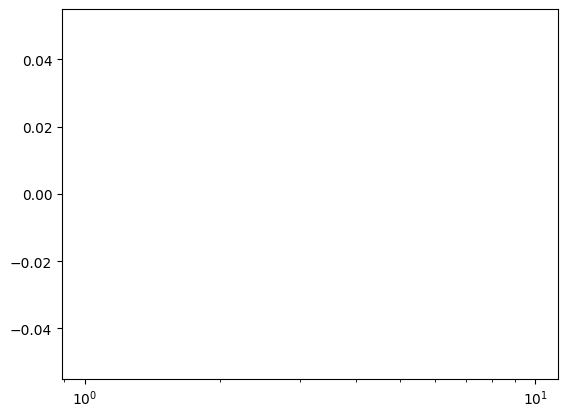

In [10]:
plt.plot(khvec,pk_g0)
plt.plot(khvec,pk_g2)
plt.plot(khvec,pk_g4)
plt.xscale('log')

### Set-Up

In [3]:
%%time
# Set usual CLASS parameters
z_pk = 0.5
cosmo = Class()
cosmo.set({'A_s':2.089e-9,
           'n_s':0.9649,
           'tau_reio':0.052,
           'omega_b':0.02237,
           'omega_cdm':0.12,
           'h':0.6736,
           'YHe':0.2425,
           'N_ur':2.0328,
           'N_ncdm':1,
           'm_ncdm':0.06,
           'z_pk':z_pk
          })  
# Set additional CLASS-PT settings
cosmo.set({'output':'mPk',
           #'non linear':'PT',
           #'IR resummation':'Yes',
           #'Bias tracers':'Yes',
           #'cb':'Yes', # use CDM+baryon spectra
           #'RSD':'Yes',
           #'AP':'Yes', # Alcock-Paczynski effect
           #'Omfid':'0.31', # fiducial Omega_m
         })
cosmo.compute()

CPU times: user 4.25 s, sys: 17.7 ms, total: 4.27 s
Wall time: 799 ms


In [4]:
# Define some wavenumbers and compute spectra, building an interpolator for P(k)
khvec = np.logspace(-3,np.log10(1),1000) # array of k in 1/Mpc
pk_int = InterpolatedUnivariateSpline(khvec,[cosmo.pk_lin(kk,z_pk) for kk in khvec],ext='zeros')

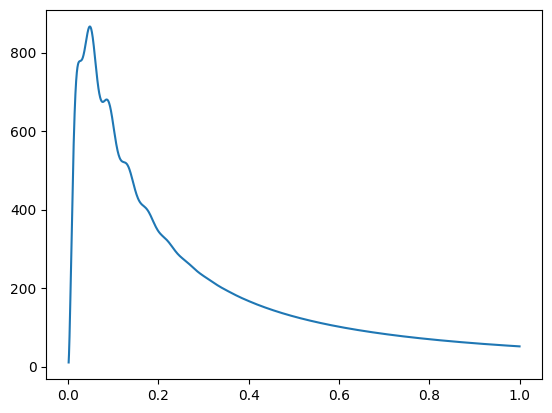

In [5]:
plt.plot(khvec,khvec*pk_int(khvec))

### Compute $P_{22}$

In [188]:
from numpy.polynomial.legendre import leggauss
from scipy.integrate import simps

k_arr = np.arange(0,0.5,0.001)[:,np.newaxis,np.newaxis] # k-values
r_arr = np.geomspace(1e-4,1e4,2000)[np.newaxis,:,np.newaxis] # relative momentum
mu_arr, w_arr = leggauss(101) # Gauss-Legendre values and weights
mu_arr = mu_arr[np.newaxis,np.newaxis,:]
w_arr = w_arr[np.newaxis,:]

# Define the integrand
psi_arr = np.sqrt(1.+r_arr**2.-2.*r_arr*mu_arr)
F2_arr = (7.*mu_arr+(3.-10.*mu_arr**2)*r_arr)/(14.*r_arr*(r_arr**2.-2.*mu_arr*r_arr+1.))
P22_integ = k_arr**3/(2.*np.pi**2)*r_arr**2*np.abs(F2_arr)**2*pk_int(psi_arr*k_arr)*pk_int(r_arr*k_arr)

# Perform numerical integration over r and mu
kk = k_arr.ravel()
P11 = pk_int(kk)
P22 = np.sum(simps(P22_integ,r_arr,axis=1)*w_arr,axis=1)

(0.001, 0.5)

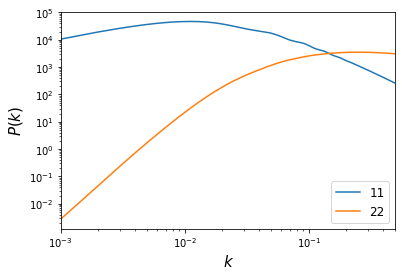

In [190]:
plt.plot(kk,P11,label='11')
plt.plot(kk,P22,label='22')
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$P(k)$',fontsize=15)
plt.xlim([1e-3,0.5])